In [1]:
%pylab inline
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import gzip
import pickle
import random
import seaborn 

Populating the interactive namespace from numpy and matplotlib


In [2]:
# A function to draw a fancy dendrogram
# Nevermind this

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

# Loading the data

We are loading the previously calculated features from  a pickle

In [3]:
data = pickle.load(open('data.pkl', 'rb'));

## Removing species with multiple strains

Use the first two words to specify the specie, and use the strain with highest number of domains.

In [4]:
allnames = data.index
exist = dict()
for name in allnames :
    shortname = ' '.join(name.split()[:2])
    if shortname not in exist :
        exist[shortname] = ( name, data.loc[name]['ndomains'] )
    
    elif data.loc[name]['ndomains'] > exist[shortname][1] :
            exist[shortname] = ( name, data.loc[name]['ndomains'] )
        

touse = [exist[shortname][0] for shortname in exist]
b=data.loc[touse]
b.index = [' '.join(name.split()[:2]) for name in b.index]
b
data = b

print ('There are {} unique species in the set.'.format(len(data)))

There are 1780 unique species in the set.


# Filtering for c-d-GMP binding domains

We are only taking species which has the 2 main c-d-GMP binding domains :
  * **GGDEF** [PF00990](http://pfam.xfam.org/family/ggdef)
  * **EAL** [PF00563](http://pfam.xfam.org/family/PF00563)

Because we know that these domains surely exist, and they tend to be contained by large connected domain co-occurrance graphs, we can also extract their *network properties* such as : 
  * Degree
  * Cluster coefficient
  * Size of containing component
  * Betweennness centrality
  * Eigenvector centrality

We also extract information about presence of additional c-d-GMP domains : 
  * **PilZ**  [PF07238](http://pfam.xfam.org/family/PF07238)
  * **MshEN** [PF05157](http://pfam.xfam.org/family/PF05157)
  
Because these may or may not exist at all in a given species, we cannot reliably use their network properties as features. 
We still calculate their degree and size of conatining component where available, but other network metrics are not kept. 


In [5]:
domains = [ 'GGDEF', 'EAL','PilZ', 'MshEN']

domains_k = [domain+'_k' for domain in domains]
domains_n = [domain+'_n' for domain in domains]
domains_c = [domain+'_c' for domain in domains[:2]]
domains_ec = [domain+'_ec' for domain in domains[:2]]
domains_bc = [domain+'_bc' for domain in domains[:2]]

In [6]:
#those with both ggdef and eal domains

data = data[ data[domains[:2]].all(axis=1) ]

print ('{} species have all of domains : {}'.format(len(data),domains[:2]))

data = data.loc[data[domains_bc].dropna().index]

print ('{} species have valid netwok properties for domains :{}'.format(len(data),domains[:2]))

data = data[['nproteins', 'ndomains'] +domains+ domains_k + domains_n +domains_c+ domains_ec+ domains_bc]

1249 species have all of domains : ['GGDEF', 'EAL']
1030 species have valid netwok properties for domains :['GGDEF', 'EAL']


In [7]:
data.to_csv('filtered_raw.csv')

data.describe()


,nproteins,ndomains,GGDEF,EAL,PilZ,MshEN,GGDEF_k,EAL_k,PilZ_k,MshEN_k,GGDEF_n,EAL_n,PilZ_n,MshEN_n,GGDEF_c,EAL_c,GGDEF_ec,EAL_ec,GGDEF_bc,EAL_bc
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,849.000000,711.000000,1030.000000,1030.000000,849.000000,711.000000,1030.000000,1030.000000,1.030000e+03,1.030000e+03,1030.000000,1030.000000
mean,3273.906796,2029.596117,21.987379,11.945631,3.096117,1.482524,11.515534,8.149515,1.209658,1.165963,94.160194,94.067961,17.832744,14.336146,0.335903,0.507839,1.966284e-01,1.536301e-01,0.160607,0.058781
std,1070.736751,330.780935,16.250075,9.161490,3.067033,1.594203,6.260560,5.000969,1.195846,0.408391,59.088744,59.156849,45.692242,44.342500,0.212315,0.260126,1.133308e-01,1.062848e-01,0.148447,0.080784
min,827.000000,917.000000,1.000000,1.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,3.000000,3.000000,1.000000,1.000000,0.000000,0.000000,3.797295e-09,3.797295e-09,0.000000,0.000000
25%,2525.000000,1821.000000,10.000000,5.000000,1.000000,0.000000,6.000000,4.000000,0.000000,1.000000,53.000000,53.000000,1.000000,2.000000,0.200000,0.317045,1.208751e-01,7.342435e-02,0.049432,0.005552
50%,3162.000000,2046.000000,18.000000,9.000000,2.000000,1.000000,11.000000,7.000000,1.000000,1.000000,80.500000,80.000000,2.000000,2.000000,0.279205,0.428571,1.961049e-01,1.431266e-01,0.114348,0.036187
75%,3881.750000,2255.000000,30.000000,17.000000,4.000000,2.000000,16.000000,11.000000,2.000000,1.000000,120.000000,120.000000,4.000000,2.000000,0.396291,0.666667,2.524059e-01,2.096285e-01,0.232605,0.080162
max,12055.000000,3204.000000,113.000000,57.000000,22.000000,12.000000,36.000000,27.000000,10.000000,3.000000,341.000000,341.000000,335.000000,335.000000,1.000000,1.000000,6.527469e-01,7.071068e-01,0.900000,1.000000


# Testing for normality

Here we use the [Shaphiro-Wilk test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) to look at the distribution of some features we measured to see if they are normally distributed or not. Those with **small p values** are not likely to be normally distributed. 

In [8]:
from scipy.stats import shapiro

for feature in sorted(data.columns) :
        x = data[feature].dropna()
        
        if len(x)>10 and std(x) >0.01: 
            x -= mean(x)
            x /= std(x)    
            pval = shapiro (x )[1]
            print ('{} : {:.5e}'.format(feature, pval))
    

EAL : 6.25785e-26
EAL_bc : 2.75100e-40
EAL_c : 1.42511e-26
EAL_ec : 3.18494e-23
EAL_k : 2.38521e-22
EAL_n : 1.34528e-24
GGDEF : 1.53351e-25
GGDEF_bc : 4.16226e-28
GGDEF_c : 2.35884e-32
GGDEF_ec : 1.55915e-18
GGDEF_k : 3.68345e-16
GGDEF_n : 1.21024e-24
MshEN : 4.94625e-33
MshEN_k : 1.72276e-41
MshEN_n : 2.80260e-45
PilZ : 1.36745e-30
PilZ_k : 1.28819e-30
PilZ_n : 1.40130e-45
ndomains : 4.62703e-03
nproteins : 2.78103e-18


**Long story short, nothing is normally distributed.** 
ndomains is closest to being a normal distribution with P value 0.046 but I guess this is no surprise. 
I don't know if this whole thing is very informative or not, but at least it tells us that we are not looking at a whole bunch of normal distributions.

# Plotting pairwise relationships

 * **Diagonals** are histograms for a given species 
 * **Off-diagonals** are pairwise scatter plots between domains -> **Each point is a species**

## Domain occurrance counts

These are simply the **number of times a domain was observed in a species.**

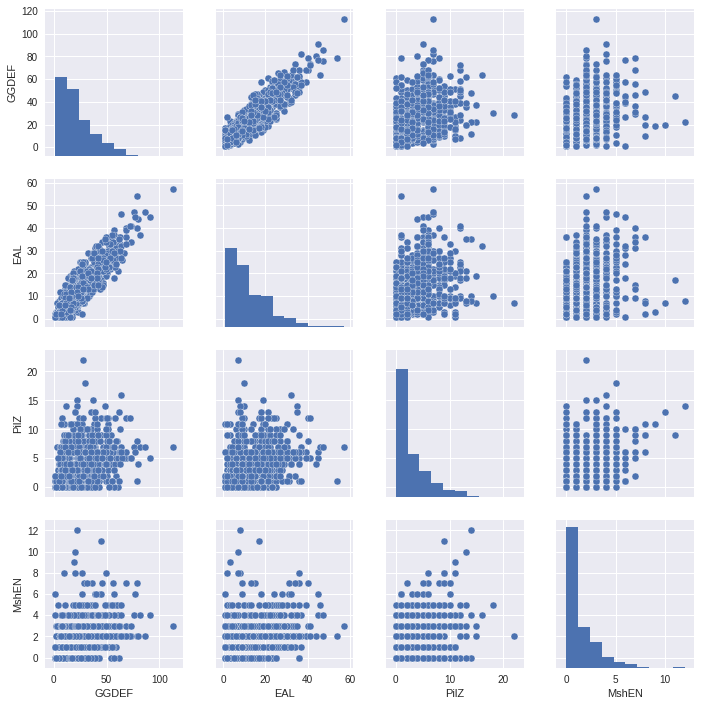

In [9]:
seaborn.pairplot(data[domains]);

We immediately observe that **number of GGDEF and EAL domains appear strongly correlated.**
We can also tell right away that the distributions are heavy tailed, that is there are many species with few domain occurrances and few species with many. 
I wouldn't go as far as to claim a power law but kind of looks scale free. 

Being scale free means the variance is divergent, therefore there may not be a well defined mean for a distribution.
For example, the mean number of GGDEF domains ~22 and std is ~16. This does represent a broad distribution with a  well defined mean. But for MshEN, mean is 1.48 and std is 1.59, which is characteristic for a scale free distribution.

I did not do rigorous analysis to decide whether this is a scale free distribution. 

## Domain co-occurrance counts

These are **the number of times a domain co-occurs with another domain in a given species**.
From a network perspective, this is the **degree** of the node representing the given domain in the domain co-occurrance network.

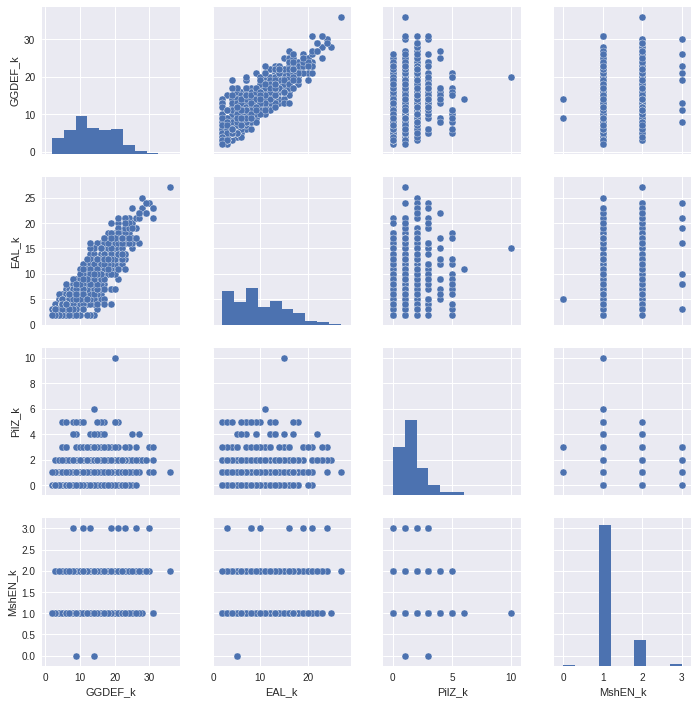

In [10]:
seaborn.pairplot(data[domains_k].dropna());

We can see a strong correlation between the degrees of GGDEF and EAL domains. 
That is to say, if GGDEF co-occurs with a lot of domains, so does EAL. 
The data gets sparser for PilZ and MshEN domains as they tend to have a much tighter distributions. 

## Size of the component conatinig the domain

When we look at the domain co-occurrance networks, we usually see **one large connected component that contains most common domains**. 
This is referred to as the core network in some literature (that we already cited, I think). 

While most common domains are usually contained by this core component, others may reside in smaller connected components, or as isolated nodes if they do not co-occur with any other domains. 

The features we call **domain_n** are the sizes of the components (of the domain co-occurrance graph) containing each domain.

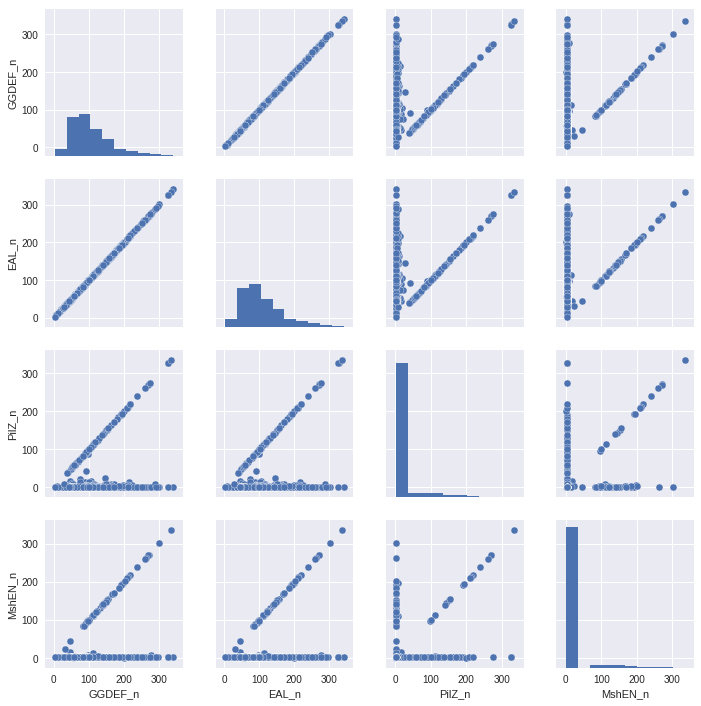

In [11]:
seaborn.pairplot(data[domains_n].dropna());

**EAL and GGDEF domains are often conatined in the same component** in the domain co-occurrence network. 
This tends to be the largest component too, but even if they are not in the largest component they tend to be together in one of the (few) larger components. 
This can be seen in the almost perfect correlation between them. 

PilZ and MshEN either appear in the same component as GGFED and EAL, or separately in much smaller components.
We can see that there are a significant number of cases where PILZ and MshEN are in much smaller components (of size <5 ) if they are not in the same large component as. 
We can also see from the PilZ vs. MshEN plot that when they are not sharing the large component with GGDEF and EAL, they tend to go their own separate ways than being in the same smaller component.


## Clustering coefficient 

These are the **[clustering coefficient](https://en.wikipedia.org/wiki/Clustering_coefficient)**s for a node representing the given domain in each species.

Since we already know that PilZ and MshEN tend to be isolated (rather than being parts of large connected graphs) we do not calculate clustring coefficients for them, which leaves us with GGDEF and EAL domains which are almost always parts of large connected components. 


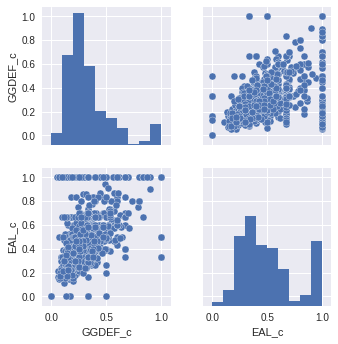

In [12]:
seaborn.pairplot(data[domains_c]);

Here we can observe that clustering coefficient of GGDEF and EAL domains are somewhat correlated, yet we can also see that EAL has a higher mean clustering coefficient. 


Roughly speaking, 
  * If domains co-occurring with GGDEF are also co-occurring with each other in a given species, this also tends to be the case with EAL. 
  * The domains that cooccur with EAL in a given species are more likely to co-occur with each other in the same species, compared to the case of GGDEF. 

## Betweennness Centrality

[Betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) is a centrality measure defined for a node in a network. 
Roughly speaking, it measures number of shortest paths that pass through the given node. 
Higher betweenness centrality suggests that this node is the bottleneck connection between two distinct modules.

As it is only meaningful for a sizeable connected component, we do not bother calculating this for MshEn and PilZ domains which tend to be in smaller components. 

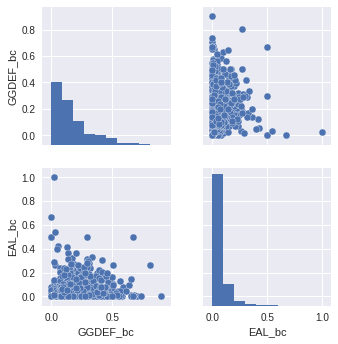

In [13]:
seaborn.pairplot(data[domains_bc].dropna());

We can see that GGDEF domains tend to have higher betweenness centrality compared to EAL domains. 
We can roughly interpret that as GGDEF domain having a higher tendency of co-occuring multiple with distinct domain groups, whereas EAL tends to co-occur within a tightly connected set of co-occurring domains. 
EAL domains ahving higher mean clustering coefficient, as shown previously, is qualitatively consistent with this observation.  

## Eigenvector centrality

[Eigenvector centrality](https://en.wikipedia.org/wiki/Eigenvector_centrality) is a measure of centrality for a node in a network. 
It is said to measure the 'influence' of a node in a network e.g. a variant of this measure is used in Google's [PageRank](https://en.wikipedia.org/wiki/PageRank) algorithm to rank websites.

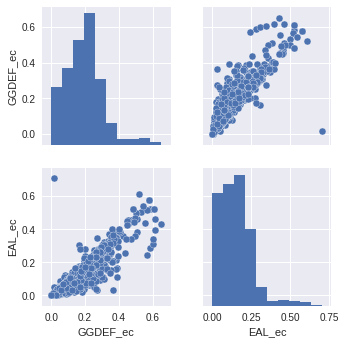

In [14]:
seaborn.pairplot(data[domains_ec].dropna());

We can see here how different centrality measures capture contradicing qualities simultaneously: Meanwhile betweenness centrality is not well correlated between GGDEF and EAL domains, eigenvalue centrlality is. 
Although the GGDEF domains tend to also have higher eigenvector centralities, means ad spreads are much closer in this case. 


# Processing features

For the rest of the analysis we are using the features : 
  * **domain** : # of occurrances for GGDEF, EAL, PilZ, MshEN
  * **domain_k** : # of co-occurrances for GGDEF and EAL
  * **domain_n** : size of component containing GGDEF ad EAL
  * **domain_c** : clustering coefficient fro GGDEF and EAL
  * **domain_bc** : betweenness centrality for GGDEF and EAL
  * **domain_ec** : eigenvalue centrality for GGDEF and EAL 

We have these **14 features** available for a total of **1030 bacterial species**.

## Standardization

Before we proceed with the analysis, we scale each feature to have a mean of 0 and variance of 1 across the 1030 species. 


In [15]:
from sklearn.preprocessing import StandardScaler
# extract feature matrix from DataFrame

X = data[domains+domains_k[:2] + domains_n[:2] + domains_c+ domains_bc+ domains_ec].dropna()

# standardize features
scl = StandardScaler()
X = scl.fit_transform(X)

print ('Size of the standardized feature matrix : {}'.format(X.shape))

Size of the standardized feature matrix : (1030, 14)


## Principle components analysis

We then do a simple PCA on the dataset to get an idea of the true dimansionality of the system. 


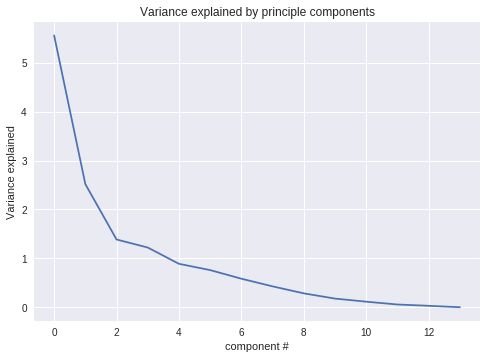

In [16]:
from sklearn.decomposition import PCA

pca = PCA()

X_hat = pca.fit_transform(X);

title('Variance explained by principle components')
ylabel('Variance explained')
xlabel('component #')
plot (pca.explained_variance_);

It appears that despite the first few principal components explaining a lot of variance, first 11 dimensions out of 14 are pretty significant.

We can use the 2 largest principal components to project this data into two dimensions. 
If there is obvious structure in the data, this might enable us to visually see it. 

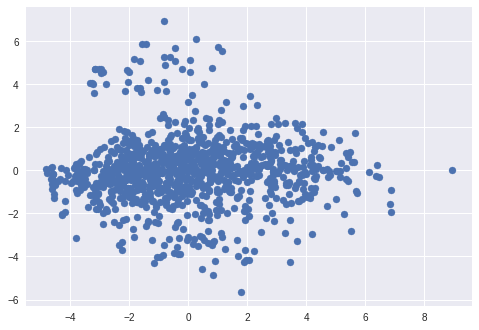

In [17]:
# Scatter plot to see if there is any obvious structure
scatter (X_hat[:,0], X_hat[:,1]);

Qualitatively speaking, there is barely any structure in this scatter plot except for maybe 2 major clusters.

## Clustering

We choose to do agglomerative clustering on the standardized features. 
After all said and done, the coice of parameters are still somewhat arbitrary. 

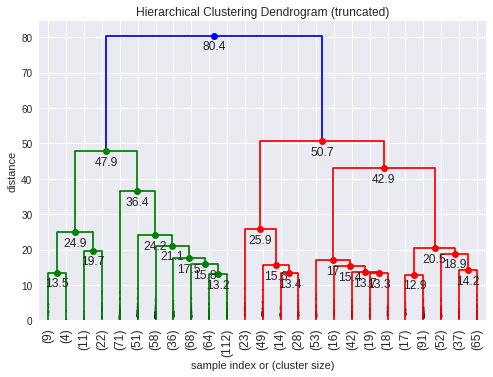

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist,squareform

set_printoptions(precision=5, suppress=True)

## do the agglomerative clustering with our features

Z = linkage(X, 'ward')


fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=25,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

This truncated tree represents the last 25 events of out clustering, in which smaller chunks are combined to make larger clusters. 
We need to decide on a cutoff distance to finalize our cluster assignments. 
I choose 30 and 15, which generate 6 and 18 clusters respectively.


In [19]:
# Choose max_d based on the previous dendrogram
# This is where we cut the tree.

max_d_coarse = 30
max_d_fine = 15

coarse_clusters = fcluster(Z, max_d_coarse, criterion='distance')
fine_clusters = fcluster(Z, max_d_fine, criterion='distance')

print('Cutting at {} yields {} clusters.'.format(max_d_coarse,len(set(coarse_clusters))))
print('Cutting at {} yields {} clusters.'.format(max_d_fine,len(set(fine_clusters))))


Cutting at 30 yields 6 clusters.
Cutting at 15 yields 18 clusters.


## Visualizing clusters using PCA projection

We can now color-code the cluster ids to visualize them in our 2-dimensional principal component projection. 
Note that in this representation axes are principal components so they do not necerrarily map to actual features. 
This is only a way to qualitatively look at the cluster structures.  

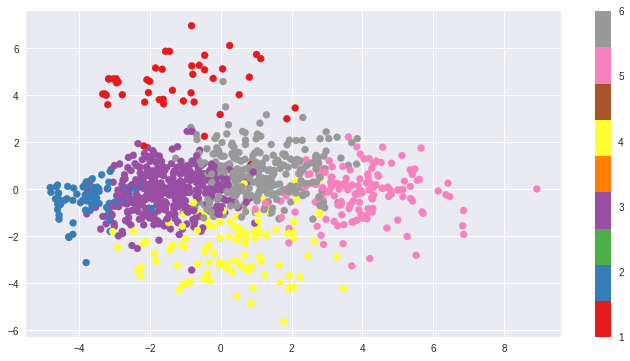

In [20]:
figsize(12, 6)
scatter (X_hat[:,0], X_hat[:,1], c=coarse_clusters, cmap='Set1')
colorbar();

Also note that I did this for the coarse clustering with 6 clusters, the fine clusters (18 of them) are also identified in the csv file in the column titled **fine_cluster**.

The red cluster (1) seems to be well distinguished from the others and might be of interest. 
The other clusters are spatially separated but without distinct boundaries between them. 
Although this is a very limited visualization (i.e. situation might be different in the remaining 12 dimensions) I would still take the clusters 2-6 with a grain of salt. 


In [21]:
## Write the cluster ids to a csv file

final = data[domains+domains_k[:2] + domains_n[:2] + domains_c+ domains_bc+ domains_ec].dropna()
final['coarse_cluster'] = coarse_clusters
final['fine_cluster'] = fine_clusters
final.to_csv('clustered.csv')


This is another way of visualizing the clustering process but I really don't see the point for our application.

In [22]:


'''
dM is the square distance matrix
'''
def plot_hierarchical_clustering(dM, labels=None, savefig=None):
    fig = plt.figure(figsize=(8,8))
    axdendro = fig.add_axes([0.1,0.8,0.8,0.2])
    Y = linkage(dM, method='ward') # You can try alternative linkage methods here
    Z = dendrogram(Y, orientation='top')#, truncate_mode='lastp',    p=12,)
    axdendro.set_xticks([])
    #axdendro.set_yticks([])

    # Plot distance matrix.
    axmatrix = fig.add_axes([0.1,0.01,0.8,0.8])
    index = Z['leaves']
    dM = dM[index,:]
    dM = dM[:,index]
    im = axmatrix.matshow(dM, aspect='auto', origin='lower', cmap='Blues')
    axmatrix.set_xticks([])
    if labels is not None:
        labels = [labels[i] for i in index]
        axmatrix.set_yticks(range(0,len(labels)))
        axmatrix.set_yticklabels(labels)
    else:
        axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([0.91,0.01,0.02,0.8])
    plt.colorbar(im, cax=axcolor)
    if savefig is not None:
        plt.savefig(savefig, bbox_inches='tight', dpi=300)
    return Y


/usr/lib/python3.6/site-packages/ipykernel/__main__.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


array([[  850.     ,  1021.     ,     0.     ,     2.     ],
       [  570.     ,   576.     ,     0.50484,     2.     ],
       [   13.     ,   268.     ,     1.00661,     2.     ],
       ..., 
       [ 2053.     ,  2054.     ,   775.28654,   286.     ],
       [ 2050.     ,  2055.     ,   830.87778,   744.     ],
       [ 2056.     ,  2057.     ,  1415.37011,  1030.     ]])

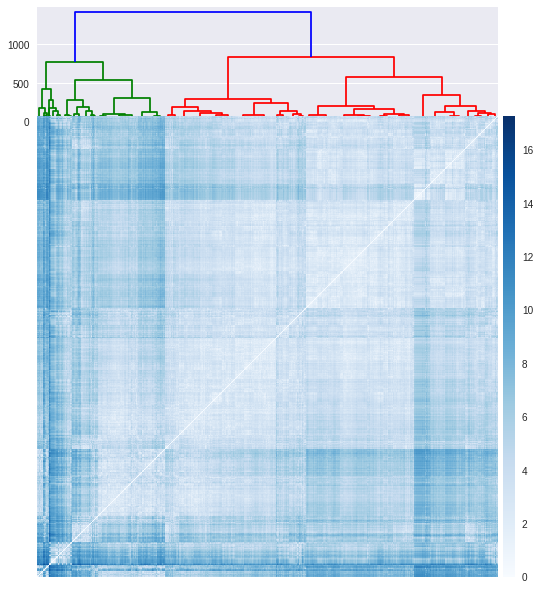

In [23]:
from scipy.spatial.distance import pdist,squareform

plot_hierarchical_clustering(squareform(pdist(X)))
